In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import time

In [0]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
print(device)

cuda


In [0]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()
    in_features, out_features = 784, 1
    self.fc1 = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
    )
    self.fc2 = nn.Sequential(
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
    )
    self.fc3 = nn.Sequential(
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
    )
    self.out = nn.Sequential(
        nn.Linear(256, out_features),
        nn.Sigmoid(),
    )

  def forward(self, x):
    x = x.view(-1,784)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.out(x)
    return x

In [0]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()
    in_features, out_features = 128, 784
    self.fc1 = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.LeakyReLU(0.2),
    )
    self.fc2 = nn.Sequential(
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
    )
    self.fc3 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
    )
    self.out = nn.Sequential(
        nn.Linear(1024, out_features),
        nn.Tanh(),
    )

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.out(x)
    return x

In [0]:
def images_to_vectors(images):
  return images.view(images.size(0), 784)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 1, 28, 28)

def noise(size):
  z = torch.randn(size, 128, device=device, requires_grad=True)
  return z

In [0]:
discriminator = Discriminator()
discriminator.to(device)
summary(discriminator, (1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         803,840
         LeakyReLU-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
         LeakyReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
         LeakyReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                    [-1, 1]             257
          Sigmoid-11                    [-1, 1]               0
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [0]:
generator = Generator()
generator.to(device)
summary(generator, (1,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          33,024
         LeakyReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 512]         131,584
         LeakyReLU-4               [-1, 1, 512]               0
            Linear-5              [-1, 1, 1024]         525,312
         LeakyReLU-6              [-1, 1, 1024]               0
            Linear-7               [-1, 1, 784]         803,600
              Tanh-8               [-1, 1, 784]               0
Total params: 1,493,520
Trainable params: 1,493,520
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.70
Estimated Total Size (MB): 5.74
----------------------------------------------------------------


In [0]:
def real(size):
  return torch.ones((size,1), device=device)
def fake(size):
  return torch.zeros((size,1), device=device)

In [0]:
batch_size = 128
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ])
data = datasets.MNIST(root='./', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

In [0]:
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
g_losses = []
d_losses = []
images = []
criterion = nn.BCELoss()
d_steps = 1
num_epochs = 200

In [0]:
def train_discriminator(optimizer,real_data,fake_data):

  optimizer.zero_grad()
  prediction_real = discriminator(real_data)
  loss_real = criterion(prediction_real,real(real_data.size(0)))
  loss_real.backward()
  loss = loss_real.data
  del prediction_real, loss_real, real_data

  prediction_fake = discriminator(fake_data)
  loss_fake = criterion(prediction_fake,fake(fake_data.size(0)))
  loss_fake.backward()
  loss += loss_fake.data
  optimizer.step()
  del prediction_fake, loss_fake, fake_data

  return loss

def train_generator(optimizer,fake_data):

  optimizer.zero_grad()
  prediction = discriminator(fake_data)
  error = criterion(prediction,real(prediction.size(0)))
  del prediction, fake_data

  error.backward()
  loss = error.data

  del error
  optimizer.step()
  return loss

In [0]:
generator.train()
discriminator.train()

total_time = 0.0
for epoch in range(num_epochs):
  
  start_time = time.time()
  g_error=0.0
  d_error=0.0
  for i,data in enumerate(data_loader):
    imgs,_ = data
    n = len(imgs)

    for j in range(d_steps):
      fake_data = generator(noise(n)).detach()
      real_data = imgs.to(device)
      d_error+=train_discriminator(d_optimizer, real_data, fake_data)
      del fake_data, real_data

    fake_data = generator(noise(n))
    g_error+=train_generator(g_optimizer,fake_data)
    del fake_data, imgs

  img = generator(noise(64)).reshape(-1,1,28,28).cpu().detach()
  img_grid = torchvision.utils.make_grid(img)
  images.append(img_grid)
  g_losses.append(g_error/i)
  d_losses.append(d_error/i)
  time_el = time.time()-start_time
  total_time += time_el
  print(f'Epoch {epoch}: g_loss: {(g_error/i):.8f} d_loss: {(d_error/i):.8f} time:{(time_el):.1f} seconds')

Epoch 0: g_loss: 2.63026142 d_loss: 0.89890325 time:10.7 seconds
Epoch 1: g_loss: 1.55626476 d_loss: 1.18410444 time:10.8 seconds
Epoch 2: g_loss: 1.32651293 d_loss: 1.16512108 time:10.9 seconds
Epoch 3: g_loss: 1.17471826 d_loss: 1.21389794 time:11.0 seconds
Epoch 4: g_loss: 1.48941636 d_loss: 1.26848638 time:10.7 seconds
Epoch 5: g_loss: 1.20242083 d_loss: 1.01392329 time:10.6 seconds
Epoch 6: g_loss: 1.57621026 d_loss: 0.95177132 time:10.7 seconds
Epoch 7: g_loss: 1.63580143 d_loss: 0.80898035 time:10.7 seconds
Epoch 8: g_loss: 1.88886225 d_loss: 0.82935190 time:10.8 seconds
Epoch 9: g_loss: 1.80518448 d_loss: 0.74595892 time:10.8 seconds
Epoch 10: g_loss: 1.65287745 d_loss: 0.84011990 time:10.7 seconds
Epoch 11: g_loss: 1.60801244 d_loss: 0.85863376 time:10.6 seconds
Epoch 12: g_loss: 1.91038823 d_loss: 0.77346480 time:10.7 seconds
Epoch 13: g_loss: 1.65872753 d_loss: 0.87346160 time:10.6 seconds
Epoch 14: g_loss: 2.03583121 d_loss: 0.72612566 time:10.6 seconds
Epoch 15: g_loss: 1.

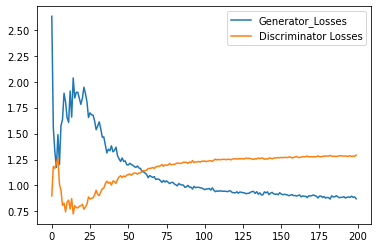

In [0]:
plt.plot(g_losses, label='Generator_Losses')
plt.plot(d_losses, label='Discriminator Losses')
plt.legend()

In [0]:
to_image = transforms.Compose([transforms.ToPILImage(),transforms.Resize((500,500))])

In [0]:
from PIL import Image
import imageio
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('progress.gif', imgs)

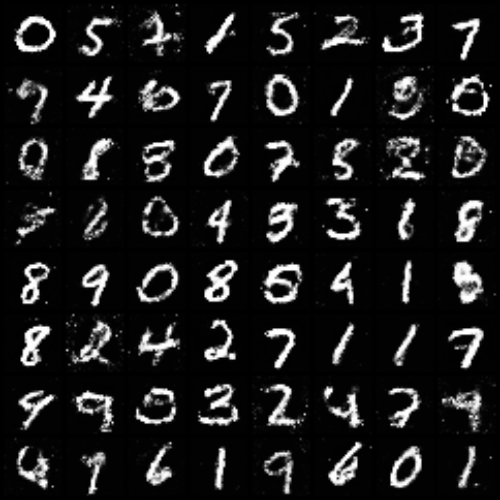

In [0]:
to_image(torchvision.utils.make_grid(generator(noise(64)).view(-1,1,28,28).cpu().detach()))

In [0]:
total = 0.0
correct = 0.0
print(device)
for i,data in enumerate(data_loader):
  img,_ = data
  img.to(device)
  prediction = discriminator(img)
  prediction = (prediction>0.5).float()
  correct += torch.sum(prediction).data.numpy()
  total += prediction.shape[0]

print(correct/total)

cuda
0.5854
